In [26]:
import pandas as pd
import seaborn as sns
import os
from FilmCollector import Film_collector
import asyncio
import nest_asyncio
from matplotlib import pyplot as plt
import json
from Utils import predict_reviews
from matplotlib import ticker

In [27]:

def dataframe_split(df_predicated):
    df_left = df_predicated[df_predicated['politics'] == 'left']
    df_right = df_predicated[df_predicated['politics'] == 'right']
    df_neutral = df_predicated[df_predicated['politics'] == 'neutral']
    df_left_1 = df_left[df_left['rating'] == 1]
    df_left_1.loc[:, 'politics'] = 'left 1'
    df_left_10 = df_left[df_left['rating'] == 10]
    df_left_10.loc[:, 'politics'] = 'left 10'
    df_right_1 = df_right[df_right['rating'] == 1]
    df_right_1.loc[:, 'politics'] = 'right 1'
    df_right_10 = df_right[df_right['rating'] == 10]
    df_right_10.loc[:, 'politics'] = 'right 10'
    df_right_filtered = df_right[~df_right['rating'].isin([1, 10])]
    df_left_filtered = df_left[~df_left['rating'].isin([1, 10])]
    
    df_concatenated = pd.concat([
        df_neutral,
        df_right_filtered,
        df_left_filtered,
        df_left_1,
        df_left_10,
        df_right_1,
        df_right_10,
    ], ignore_index=True)
    
    df_concatenated = df_concatenated.dropna(subset=['rating'])
    return df_concatenated

In [28]:
def list_folders(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

folder_path = 'Data'  
folders = list_folders(folder_path)
print(folders)

['tt0097216', 'tt0892769', 'tt5672290', 'tt0395169', 'tt0249462', 'tt6133466', 'tt7713068', 'tt0286716', 'tt0093300', 'tt13975458', 'tt0068334', 'tt12262202', 'tt1785612', 'tt0145487', 'tt11003218', 'tt10676048', 'tt0103923', 'tt3480822', 'tt8075192', 'tt0364569', 'tt12037194', 'tt3169706', 'tt1206885']


In [29]:
nest_asyncio.apply()
collector = Film_collector()

async def get_film_data(imdb_id):
    return await collector.get_all(imdb_id, False, False)

async def process_films():
    results = []
    for film_link in folders:
        data = await get_film_data(film_link)
        results.append(data)
    return results

film_datas = asyncio.get_event_loop().run_until_complete(process_films())


In [30]:
def compute_ratings(films):
    neutral_diff_ = []
    left_right_neutral_diff_ = []
    all_diff_ = []
    for film in films:
        film_data, film_rev = film 
        split = dataframe_split(predict_reviews(film_rev))
        df_split_neutral = split[split['politics'] == 'neutral']
        df_split_left_right_neutral = split[split['politics'].isin(['left', 'right', 'neutral'])]
        df_all = split
        mean_rating_neutral = df_split_neutral['rating'].mean()
        mean_rating_left_right_neutral = df_split_left_right_neutral['rating'].mean()
        mean_rating_all = df_all['rating'].mean()
        film_data = json.loads(film_data)
        rating_value = film_data['rating']['ratingValue']
        neutral_diff_.append(rating_value - mean_rating_neutral)
        left_right_neutral_diff_.append(rating_value - mean_rating_left_right_neutral)
        all_diff_.append(rating_value - mean_rating_all)
    return neutral_diff_, left_right_neutral_diff_, all_diff_

How to Train Your Dragon
The First Omen
Hulk
Jaws: The Revenge
Cube: Ichido haittara, saigo
The Acolyte
Spider-Man
Pig
The Marvels
Captain America
Manbiki kazoku
Oldeuboi
Furiosa: A Mad Max Saga
Rambo: Last Blood


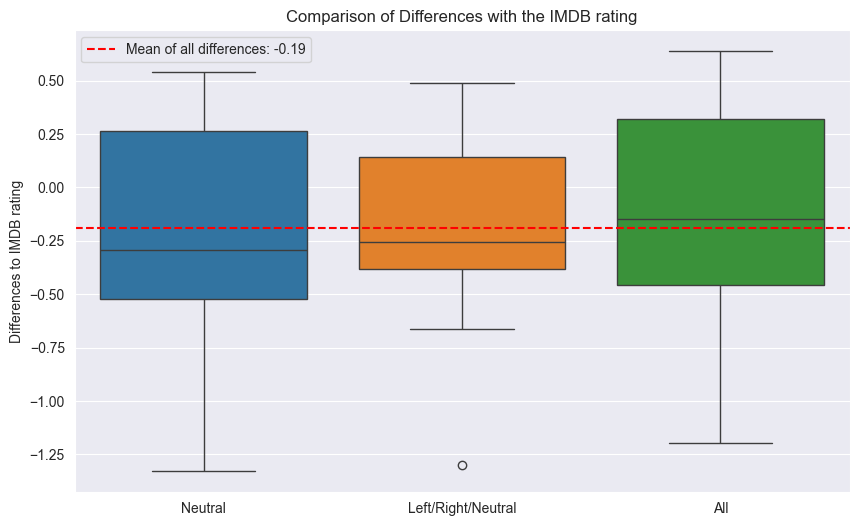

In [31]:

def distribution_difference_rating(film_diff):
    neutral_diff, left_right_neutral_diff, all_diff = compute_ratings(film_diff)
    data = [neutral_diff, left_right_neutral_diff, all_diff]
    
    mean_neutral_diff = sum(neutral_diff) / len(neutral_diff)
    mean_left_right_neutral_diff = sum(left_right_neutral_diff) / len(left_right_neutral_diff)
    mean_all_diff = sum(all_diff) / len(all_diff)
    
    complete_mean = (mean_neutral_diff + mean_left_right_neutral_diff + mean_all_diff) / 3
    labels = ['Neutral', 'Left/Right/Neutral', 'All']
    plt.figure(figsize=(10, 6))
    ax = plt.gca() 
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10)) 
    
    sns.boxplot(data=data)
    plt.xticks(ticks=range(len(labels)), labels=labels)
    
    plt.axhline(y=complete_mean, color='r', linestyle='--', label=f'Mean of all differences: {complete_mean:.2f}')
    plt.title('Comparison of Differences with the IMDB rating')
    plt.ylabel('Differences to IMDB rating')
    plt.legend() 
    plt.show()

non_political_film = [] 

for film in film_datas:
    film_data, film_rev = film
    film_d = json.loads(film_data)


    if film_d.get('political_m', True): 
        continue  
    else:
        print(film_d['name'])
        non_political_film.append(film)  

distribution_difference_rating(non_political_film)

Do the Right Thing
Hotel Rwanda
Billy Elliot
The First Purge
Birds of Prey and the Fantabulous Emancipation of One Harley Quinn
The Candidate
The Punk Singer
Black Widow
Pride


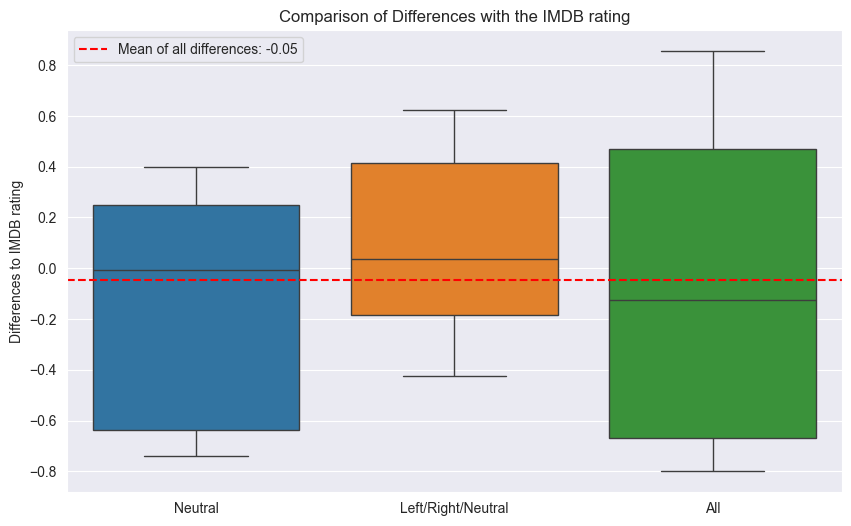

In [32]:

political_film = []

for film in film_datas:
    film_data, film_rev = film
    film_d = json.loads(film_data)

    if film_d.get('political_m', False):
        print(film_d['name'])
        political_film.append(film)

distribution_difference_rating(political_film)
